In [1]:
# Import
% matplotlib inline
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from scipy.stats import zscore
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Import data
data = pd.read_csv('Data/prices.csv', parse_dates=['Date'], low_memory=False)

In [3]:
data.dtypes

Date                               datetime64[ns]
BOLSAA_Price                              float64
Bovespa_Brazil_50_Price                   float64
CAD_USD_Price                             float64
Canada_10Y_BY_Price                       float64
Canada_30Y_BY_Price                       float64
EUR_USD_Price                             float64
Euro_Stoxx_50_Price                       float64
JPY_USD_Price                             float64
Nikkei_225_Price                          float64
Shanghai_Shenzhen_CSI_300_Price           float64
SnP_TSX_Composite_Price                   float64
SnP_500_Price                             float64
US_10Y_BY_Price                           float64
US_30Y_BY.csv_Price                       float64
Holiday                                      bool
weekend                                      bool
month                                      object
quarter                                    object
dtype: object

In [4]:
data.head()

,Date,BOLSAA_Price,Bovespa_Brazil_50_Price,CAD_USD_Price,Canada_10Y_BY_Price,Canada_30Y_BY_Price,EUR_USD_Price,Euro_Stoxx_50_Price,JPY_USD_Price,Nikkei_225_Price,Shanghai_Shenzhen_CSI_300_Price,SnP_TSX_Composite_Price,SnP_500_Price,US_10Y_BY_Price,US_30Y_BY.csv_Price,Holiday,weekend,month,quarter
0,2018-05-22,31.68,13880.49,0.7803,2.516,2.501,1.1788,3587.25,0.00903,22960.34,3906.21,16144.79,2724.44,3.063,3.207,False,False,May,Q2
1,2018-05-21,32.06,13742.45,0.7827,2.516,2.501,1.1790,3572.57,0.00901,23002.37,3921.24,16144.79,2733.01,3.058,3.201,False,False,May,Q2
2,2018-05-18,32.17,13964.08,0.7763,2.486,2.496,1.1778,3573.76,0.00903,22930.36,3903.06,16162.31,2712.97,3.060,3.202,False,False,May,Q2
3,2018-05-17,32.88,14056.13,0.7809,2.520,2.528,1.1795,3592.18,0.00902,22838.37,3864.05,16143.55,2720.13,3.115,3.250,False,False,May,Q2
4,2018-05-16,32.80,14550.31,0.7821,2.501,2.512,1.1807,3562.85,0.00906,22717.23,3892.84,16108.06,2722.46,3.104,3.223,False,False,May,Q2


In [5]:
data.drop(['Date', 'Holiday', 'weekend', 'month', 'quarter'], axis=1, inplace=True)

In [6]:
data.shape

(1744, 14)

In [7]:
data = data[::-1]

In [8]:
sum(data.isnull().sum() >0)

0

In [9]:
corr = data.corr()
corr.style.background_gradient()

,BOLSAA_Price,Bovespa_Brazil_50_Price,CAD_USD_Price,Canada_10Y_BY_Price,Canada_30Y_BY_Price,EUR_USD_Price,Euro_Stoxx_50_Price,JPY_USD_Price,Nikkei_225_Price,Shanghai_Shenzhen_CSI_300_Price,SnP_TSX_Composite_Price,SnP_500_Price,US_10Y_BY_Price,US_30Y_BY.csv_Price
BOLSAA_Price,1,0.615935,-0.183222,0.071721,-0.111264,-0.110032,0.395107,-0.320535,0.449838,0.224818,0.40587,0.522407,0.246861,0.0146076
Bovespa_Brazil_50_Price,0.615935,1,-0.354141,0.135562,-0.154093,-0.207261,0.527672,-0.259365,0.590072,0.519419,0.694336,0.734284,0.391439,-0.101124
CAD_USD_Price,-0.183222,-0.354141,1,0.581043,0.657485,0.867023,-0.752985,0.81581,-0.848702,-0.74435,-0.685494,-0.824704,-0.103098,0.457909
Canada_10Y_BY_Price,0.071721,0.135562,0.581043,1,0.940279,0.784452,-0.147372,0.286548,-0.208787,-0.408138,-0.103749,-0.200477,0.718225,0.874167
Canada_30Y_BY_Price,-0.111264,-0.154093,0.657485,0.940279,1,0.812395,-0.27494,0.33567,-0.367976,-0.556652,-0.277531,-0.407948,0.618889,0.934979
EUR_USD_Price,-0.110032,-0.207261,0.867023,0.784452,0.812395,1,-0.559354,0.635249,-0.643849,-0.734252,-0.468568,-0.606032,0.234511,0.657242
Euro_Stoxx_50_Price,0.395107,0.527672,-0.752985,-0.147372,-0.27494,-0.559354,1,-0.885819,0.939904,0.703642,0.885546,0.893691,0.46716,-0.0917028
JPY_USD_Price,-0.320535,-0.259365,0.81581,0.286548,0.33567,0.635249,-0.885819,1,-0.906853,-0.623011,-0.731074,-0.803874,-0.36553,0.122997
Nikkei_225_Price,0.449838,0.590072,-0.848702,-0.208787,-0.367976,-0.643849,0.939904,-0.906853,1,0.784699,0.857624,0.955391,0.438673,-0.172472
Shanghai_Shenzhen_CSI_300_Price,0.224818,0.519419,-0.74435,-0.408138,-0.556652,-0.734252,0.703642,-0.623011,0.784699,1,0.622558,0.726689,0.0690482,-0.443813


In [10]:
# Scale data
#def mean_val = list()
#def max_val = list()
#def min_val = list()
#mean_val = np.mean(series)
#max_val = max(series)
#min_val = min(series)
def normalize(series):
    return (series - np.mean(series))/(max(series) - min(series))

data_norm = data.apply(normalize)

In [11]:
data_norm.head()

,BOLSAA_Price,Bovespa_Brazil_50_Price,CAD_USD_Price,Canada_10Y_BY_Price,Canada_30Y_BY_Price,EUR_USD_Price,Euro_Stoxx_50_Price,JPY_USD_Price,Nikkei_225_Price,Shanghai_Shenzhen_CSI_300_Price,SnP_TSX_Composite_Price,SnP_500_Price,US_10Y_BY_Price,US_30Y_BY.csv_Price
1743,-0.402050,-0.199446,0.443088,0.338416,0.407178,0.535464,-0.384621,0.592551,-0.416693,-0.039119,-0.233589,-0.410328,0.066042,0.404758
1742,-0.393055,-0.203757,0.437310,0.311606,0.392777,0.526490,-0.385063,0.592551,-0.415376,-0.045333,-0.262796,-0.416941,0.018802,0.350632
1741,-0.389057,-0.191136,0.443088,0.281579,0.357639,0.530371,-0.381000,0.592551,-0.418519,-0.048875,-0.253455,-0.416304,-0.014209,0.293290
1740,-0.426538,-0.223590,0.413906,0.230105,0.303491,0.507572,-0.448899,0.592551,-0.425629,-0.064719,-0.328507,-0.446321,-0.070555,0.217727
1739,-0.452025,-0.238390,0.414484,0.230641,0.303491,0.523822,-0.474823,0.611782,-0.439693,-0.072858,-0.362745,-0.455974,-0.071124,0.203258


In [12]:
train_index = round(len(data_norm)*0.8)

In [13]:
# convert series to supervised learning
def series_to_supervised(data, delay=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    for i in range(delay, 0, -1):
        cols.append(data.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg =  pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
lagged_data = series_to_supervised(data_norm, 3)

In [15]:
lagged_data.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1)
1740,-0.402050,-0.199446,0.443088,0.338416,0.407178,0.535464,-0.384621,0.592551,-0.416693,-0.039119,...,0.357639,0.530371,-0.381000,0.592551,-0.418519,-0.048875,-0.253455,-0.416304,-0.014209,0.293290
1739,-0.393055,-0.203757,0.437310,0.311606,0.392777,0.526490,-0.385063,0.592551,-0.415376,-0.045333,...,0.303491,0.507572,-0.448899,0.592551,-0.425629,-0.064719,-0.328507,-0.446321,-0.070555,0.217727
1738,-0.389057,-0.191136,0.443088,0.281579,0.357639,0.530371,-0.381000,0.592551,-0.418519,-0.048875,...,0.303491,0.523822,-0.474823,0.611782,-0.439693,-0.072858,-0.362745,-0.455974,-0.071124,0.203258
1737,-0.426538,-0.223590,0.413906,0.230105,0.303491,0.507572,-0.448899,0.592551,-0.425629,-0.064719,...,0.301763,0.514606,-0.461561,0.592551,-0.445400,-0.082002,-0.351114,-0.455810,-0.047220,0.218263
1736,-0.452025,-0.238390,0.414484,0.230641,0.303491,0.523822,-0.474823,0.611782,-0.439693,-0.072858,...,0.343238,0.533524,-0.452514,0.592551,-0.438830,-0.068775,-0.299544,-0.434087,-0.019331,0.253097


In [16]:
data_norm = data_norm.shift(3).dropna()

In [17]:
data_norm.head()

,BOLSAA_Price,Bovespa_Brazil_50_Price,CAD_USD_Price,Canada_10Y_BY_Price,Canada_30Y_BY_Price,EUR_USD_Price,Euro_Stoxx_50_Price,JPY_USD_Price,Nikkei_225_Price,Shanghai_Shenzhen_CSI_300_Price,SnP_TSX_Composite_Price,SnP_500_Price,US_10Y_BY_Price,US_30Y_BY.csv_Price
1740,-0.402050,-0.199446,0.443088,0.338416,0.407178,0.535464,-0.384621,0.592551,-0.416693,-0.039119,-0.233589,-0.410328,0.066042,0.404758
1739,-0.393055,-0.203757,0.437310,0.311606,0.392777,0.526490,-0.385063,0.592551,-0.415376,-0.045333,-0.262796,-0.416941,0.018802,0.350632
1738,-0.389057,-0.191136,0.443088,0.281579,0.357639,0.530371,-0.381000,0.592551,-0.418519,-0.048875,-0.253455,-0.416304,-0.014209,0.293290
1737,-0.426538,-0.223590,0.413906,0.230105,0.303491,0.507572,-0.448899,0.592551,-0.425629,-0.064719,-0.328507,-0.446321,-0.070555,0.217727
1736,-0.452025,-0.238390,0.414484,0.230641,0.303491,0.523822,-0.474823,0.611782,-0.439693,-0.072858,-0.362745,-0.455974,-0.071124,0.203258


In [18]:
train_data = {}
test_data = {}
train_dep = {}
test_dep = {}

for col_names in data_norm.columns:
    print(col_names, "\n")
    train_data[col_names] = data_norm.iloc[:train_index,:].drop(col_names, axis=1)
    test_data[col_names] = data_norm.iloc[train_index:,:].drop(col_names, axis=1)

    train_dep[col_names] = data_norm.iloc[:train_index][col_names]
    test_dep[col_names] = data_norm.iloc[train_index:][col_names]

BOLSAA_Price 

Bovespa_Brazil_50_Price 

CAD_USD_Price 

Canada_10Y_BY_Price 

Canada_30Y_BY_Price 

EUR_USD_Price 

Euro_Stoxx_50_Price 

JPY_USD_Price 

Nikkei_225_Price 

Shanghai_Shenzhen_CSI_300_Price 

SnP_TSX_Composite_Price 

SnP_500_Price 

US_10Y_BY_Price 

US_30Y_BY.csv_Price 



In [19]:
train_x = train_data['CAD_USD_Price']
test_x = test_data['CAD_USD_Price']
train_y = train_dep['CAD_USD_Price']
test_y = test_dep['CAD_USD_Price']

In [20]:
print(train_x.shape, test_x.shape)

(1395, 13) (346, 13)


In [21]:
train_x = pd.concat([train_x, lagged_data.iloc[:train_index,:]], axis=1)
train_x.head()
#train_x.shift(3).head().dropna()

,BOLSAA_Price,Bovespa_Brazil_50_Price,Canada_10Y_BY_Price,Canada_30Y_BY_Price,EUR_USD_Price,Euro_Stoxx_50_Price,JPY_USD_Price,Nikkei_225_Price,Shanghai_Shenzhen_CSI_300_Price,SnP_TSX_Composite_Price,...,var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1)
1740,-0.402050,-0.199446,0.338416,0.407178,0.535464,-0.384621,0.592551,-0.416693,-0.039119,-0.233589,...,0.357639,0.530371,-0.381000,0.592551,-0.418519,-0.048875,-0.253455,-0.416304,-0.014209,0.293290
1739,-0.393055,-0.203757,0.311606,0.392777,0.526490,-0.385063,0.592551,-0.415376,-0.045333,-0.262796,...,0.303491,0.507572,-0.448899,0.592551,-0.425629,-0.064719,-0.328507,-0.446321,-0.070555,0.217727
1738,-0.389057,-0.191136,0.281579,0.357639,0.530371,-0.381000,0.592551,-0.418519,-0.048875,-0.253455,...,0.303491,0.523822,-0.474823,0.611782,-0.439693,-0.072858,-0.362745,-0.455974,-0.071124,0.203258
1737,-0.426538,-0.223590,0.230105,0.303491,0.507572,-0.448899,0.592551,-0.425629,-0.064719,-0.328507,...,0.301763,0.514606,-0.461561,0.592551,-0.445400,-0.082002,-0.351114,-0.455810,-0.047220,0.218263
1736,-0.452025,-0.238390,0.230641,0.303491,0.523822,-0.474823,0.611782,-0.439693,-0.072858,-0.362745,...,0.343238,0.533524,-0.452514,0.592551,-0.438830,-0.068775,-0.299544,-0.434087,-0.019331,0.253097


In [22]:
test_x.head()

,BOLSAA_Price,Bovespa_Brazil_50_Price,Canada_10Y_BY_Price,Canada_30Y_BY_Price,EUR_USD_Price,Euro_Stoxx_50_Price,JPY_USD_Price,Nikkei_225_Price,Shanghai_Shenzhen_CSI_300_Price,SnP_TSX_Composite_Price,SnP_500_Price,US_10Y_BY_Price,US_30Y_BY.csv_Price
345,0.007245,0.149554,-0.094292,-0.073813,-0.396624,0.144371,-0.215141,0.210264,0.083807,0.300445,0.189230,0.105882,-0.023430
344,-0.017743,0.159813,-0.108769,-0.083606,-0.369944,0.139196,-0.195910,0.192618,0.085922,0.293199,0.189230,0.075717,-0.047546
343,-0.023240,0.156072,-0.087321,-0.061716,-0.389833,0.144082,-0.234372,0.197682,0.089904,0.284888,0.191486,0.134340,0.001221
342,-0.019742,0.152796,-0.058903,-0.035219,-0.381829,0.142081,-0.234372,0.208824,0.086819,0.287173,0.186862,0.158244,0.014619
341,-0.018742,0.163883,-0.064801,-0.028306,-0.372370,0.147048,-0.234372,0.212937,0.094655,0.313547,0.191159,0.156537,0.016763


In [23]:
test_x = pd.concat([test_x, lagged_data.iloc[train_index:,:]], axis=1)

In [24]:
test_x.shape

(346, 55)

In [25]:
train_x_vals = train_x.values
train_X = train_x_vals.reshape((train_x.shape[0],1, train_x.shape[1]))
test_x_vals = test_x.values
test_X = test_x_vals.reshape((test_x.shape[0],1, test_x.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1395, 1, 55) (1395,) (346, 1, 55) (346,)


In [35]:
input_layer = Input(shape=(train_X.shape[1], train_X.shape[2],), dtype='float32')
# design network

lstm_layer1 = LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='linear')(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer1)
lstm_layer2 = LSTM(50, input_shape=(train_X.shape[1], 100), return_sequences=True, activation='relu')(dropout_layer)
dropout_layer = Dropout(0.2)(lstm_layer2)
lstm_layer3 = LSTM(30, input_shape=(train_X.shape[1], 50), return_sequences=True, activation='relu')(dropout_layer)
dropout_layer = Dropout(0.1)(lstm_layer3)
lstm_layer4 = LSTM(10, input_shape=(train_X.shape[1], 30), return_sequences=False, activation='relu')(dropout_layer)
dropout_layer = Dropout(0.2)(lstm_layer4)

output_layer = Dense(1, activation='linear')(dropout_layer)

ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mae', optimizer='adam')

ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 55)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 100)            62400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 50)             30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 30)             9720      
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 30)             0         
__________

In [36]:

save_weights_at  = 'CAD_USD_Price_best.hdf5'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
fit_res = ts_model.fit(x=train_X, y=train_y, epochs=30,
             verbose=1, callbacks=[save_best], validation_data=(test_X, test_y),
             shuffle=False)

Train on 1395 samples, validate on 346 samples
Epoch 1/30
1395/1395 [==============================] - 6s 5ms/step - loss: 0.2824 - val_loss: 0.3029
Epoch 2/30
1395/1395 [==============================] - 0s 312us/step - loss: 0.2203 - val_loss: 0.2863
Epoch 3/30
1395/1395 [==============================] - 0s 285us/step - loss: 0.2094 - val_loss: 0.2802
Epoch 4/30
1395/1395 [==============================] - ETA: 0s - loss: 0.143 - 0s 308us/step - loss: 0.1590 - val_loss: 0.2219
Epoch 5/30
1395/1395 [==============================] - 0s 287us/step - loss: 0.1617 - val_loss: 0.0833
Epoch 6/30
1395/1395 [==============================] - 0s 292us/step - loss: 0.2167 - val_loss: 0.1839
Epoch 7/30
1395/1395 [==============================] - 0s 300us/step - loss: 0.1126 - val_loss: 0.1509
Epoch 8/30
1395/1395 [==============================] - 0s 348us/step - loss: 0.0941 - val_loss: 0.1031
Epoch 9/30
1395/1395 [==============================] - 0s 315us/step - loss: 0.0852 - val_loss: 0.

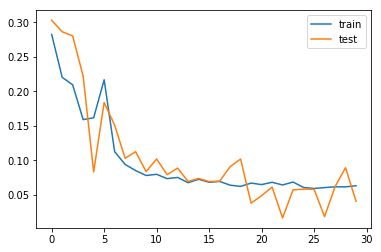

In [37]:
plt.plot(fit_res.history['loss'], label='train')
plt.plot(fit_res.history['val_loss'], label='test')
plt.legend()
plt.show()

In [38]:
best_model = load_model('CAD_USD_Price_best.hdf5')
preds = best_model.predict(test_X)

Text(0.5,0,'Index')

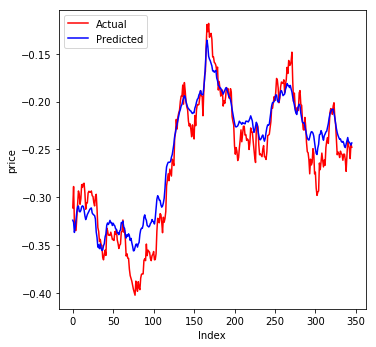

In [39]:
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(0,346), test_y, linestyle='-', color='r')
plt.plot(range(0,346), preds, linestyle='-', color='b')
plt.legend(['Actual','Predicted'], loc=2)
#plt.title('Actual vs Predicted pm2.5')
plt.ylabel('price')
plt.xlabel('Index')

In [40]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_y, preds))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.021


In [42]:
def dropval(series, position=0, days=1, percent=0):
    result = np.array([])
    progress = (percent/100)/days
    print("Step of progress {}".format(progress))
    if position!=0:
        result = np.append(result, series[:position])
    if(progress==0):
        print("No drop value mentioned")
    else:
        for i in range(days):
            loc = (len(series) - (position+i+1))
            newvalue = (series[loc] - abs(series[loc] * (i+1) * progress))
            print("loc is {}".format(loc))
            print("Series original val {}".format(series[loc]))
            print(f"Series new vallue {newvalue}")
            result = np.append(result, newvalue)
            
        for i in range(days,0,-1):
            loc = (len(series) - (position+i+1+days))
            newvalue = (series[loc] - abs(series[loc] * (i+1) * progress))
            print("loc is {}".format(loc))
            print("Series original val {}".format(series[loc]))
            print(f"Series new vallue {newvalue}")
            result = np.append(result, newvalue)    
        result = np.append(result, series[(position+(2*days)):])
    return result

Step of progress 0.04
loc is 145
Series original val -0.21321784580098835
Series new vallue -0.2217465596330279
loc is 144
Series original val -0.22283323041637323
Series new vallue -0.2406598888496831
loc is 143
Series original val -0.21706399964714204
Series new vallue -0.2431116796047991
loc is 142
Series original val -0.20552553810868063
Series new vallue -0.23840962420606954
loc is 141
Series original val -0.21706399964714204
Series new vallue -0.26047679957657044
loc is 135
Series original val -0.2189870765702192
Series new vallue -0.27154397494707183
loc is 136
Series original val -0.21706399964714204
Series new vallue -0.26047679957657044
loc is 137
Series original val -0.21706399964714204
Series new vallue -0.25179423959068475
loc is 138
Series original val -0.22091015349329604
Series new vallue -0.24741937191249158
loc is 139
Series original val -0.22091015349329604
Series new vallue -0.23858296577275973


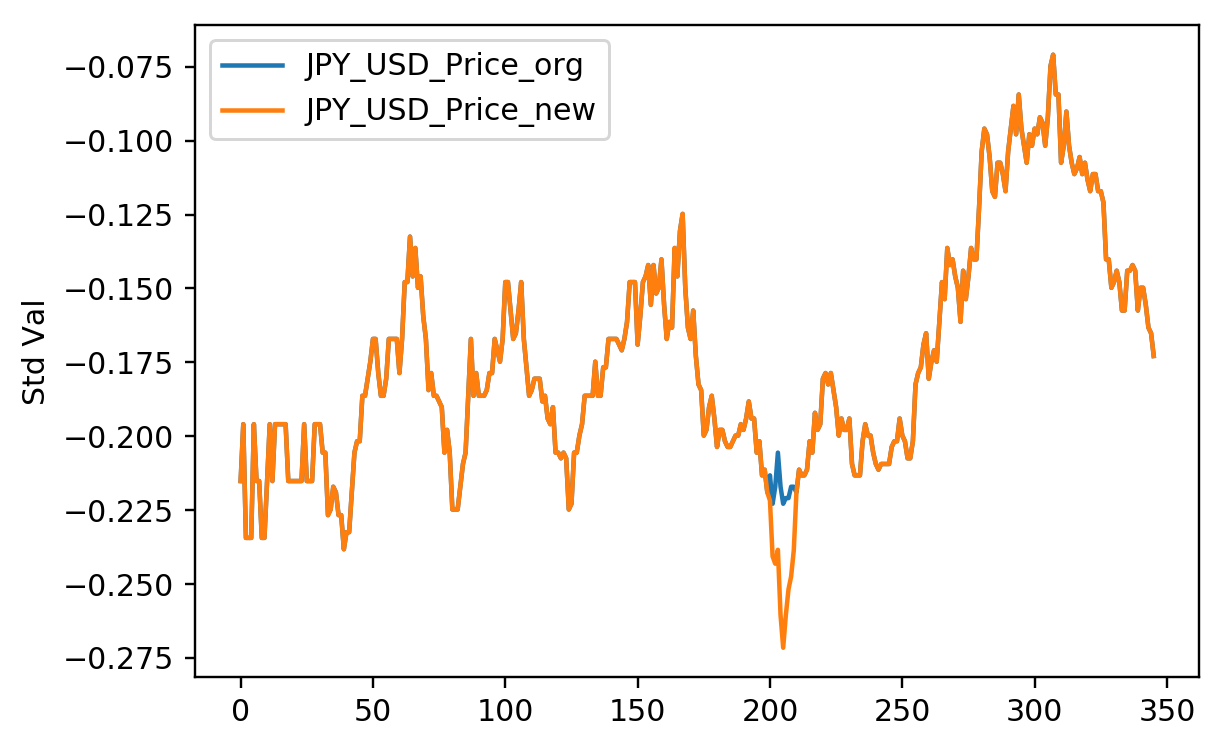

In [43]:
JPY_USD_Price_org = test_x['JPY_USD_Price'].copy()
new_price = JPY_USD_Price_org.copy()

new_price = dropval(new_price,position=200,days=5,percent=20)
test_x['JPY_USD_Price'] = new_price

fig, ax=plt.subplots(dpi=3*72)
ax.plot(range(0,346),JPY_USD_Price_org,label='JPY_USD_Price_org')
ax.plot(range(0,346),new_price,label='JPY_USD_Price_new')
plt.ylabel('Std Val')
ax.legend(loc='upper left')

Step of progress 0.04
loc is 145
Series original val 0.3739046335995043
Series new vallue 0.35894844825552413
loc is 144
Series original val 0.37591914863131937
Series new vallue 0.3458456167408138
loc is 143
Series original val 0.39274874295960777
Series new vallue 0.3456188938044548
loc is 142
Series original val 0.3929504450243602
Series new vallue 0.33007837382046257
loc is 141
Series original val 0.39294668660079357
Series new vallue 0.31435734928063486
loc is 135
Series original val 0.449461475371125
Series new vallue 0.34159072128205503
loc is 136
Series original val 0.4509510639114409
Series new vallue 0.36076085112915274
loc is 137
Series original val 0.4265682910217018
Series new vallue 0.3583173644582295
loc is 138
Series original val 0.4265682910217018
Series new vallue 0.37538009609909756
loc is 139
Series original val 0.4259901201963395
Series new vallue 0.3919109105806323


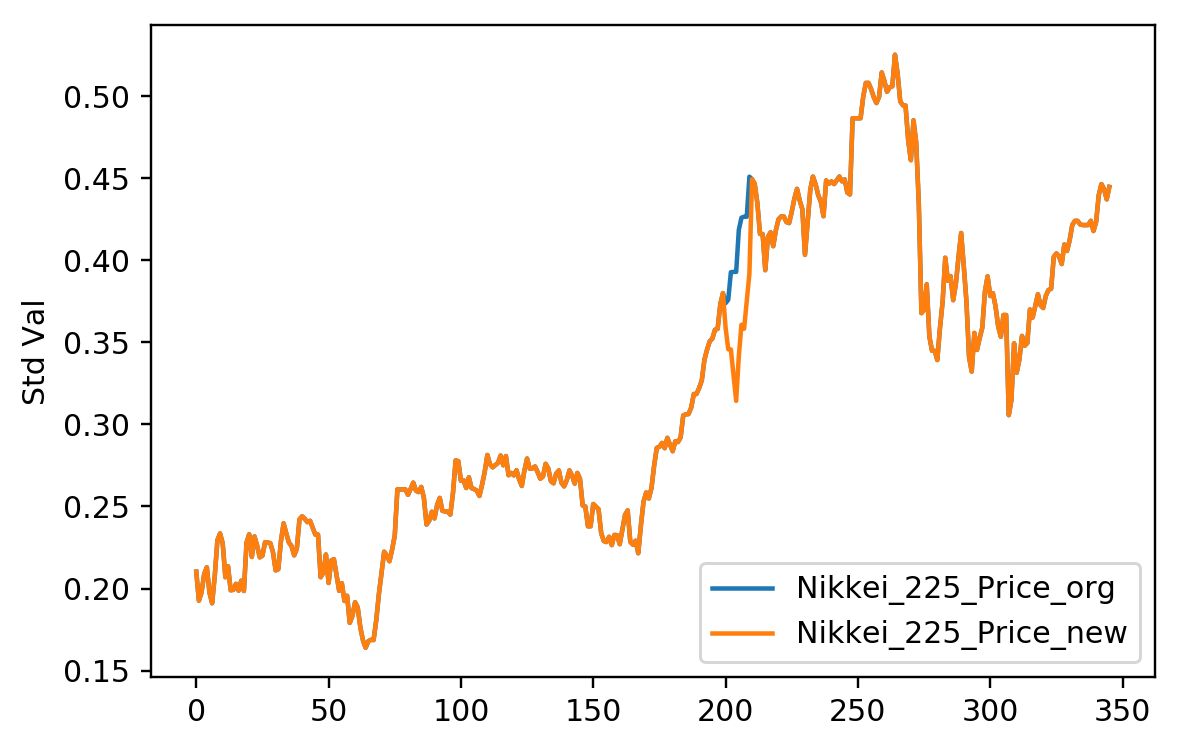

In [44]:
Nikkei_225_Price_org = test_x['Nikkei_225_Price'].copy()
new_price = Nikkei_225_Price_org.copy()

new_price = dropval(new_price,position=200,days=5,percent=20)
test_x['Nikkei_225_Price'] = new_price

fig, ax=plt.subplots(dpi=3*72)
ax.plot(range(0,346),Nikkei_225_Price_org,label='Nikkei_225_Price_org')
ax.plot(range(0,346),new_price,label='Nikkei_225_Price_new')
#ax = plt.subplot(111)
plt.ylabel('Std Val')
ax.legend(loc='lower right')
#plt.show()

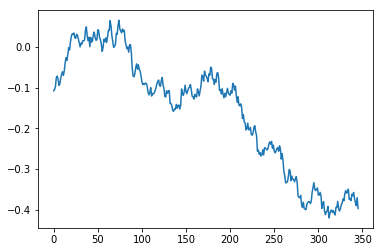

In [45]:
test_x['EUR_USD_Price'].plot()

Step of progress 0.04
loc is 145
Series original val -0.10314842670452394
Series new vallue -0.1072743637727049
loc is 144
Series original val -0.14268274637466702
Series new vallue -0.1540973660846404
loc is 143
Series original val -0.15238441991335244
Series new vallue -0.17067055030295475
loc is 142
Series original val -0.1424402045361999
Series new vallue -0.1652306372619919
loc is 141
Series original val -0.14365291372853545
Series new vallue -0.17238349647424253
loc is 135
Series original val -0.15602254749035963
Series new vallue -0.19346795888804594
loc is 136
Series original val -0.15796288219809648
Series new vallue -0.18955545863771578
loc is 137
Series original val -0.15238441991335244
Series new vallue -0.17676592709948882
loc is 138
Series original val -0.15262696175181956
Series new vallue -0.1709421971620379
loc is 139
Series original val -0.14074241166693013
Series new vallue -0.15200180460028453


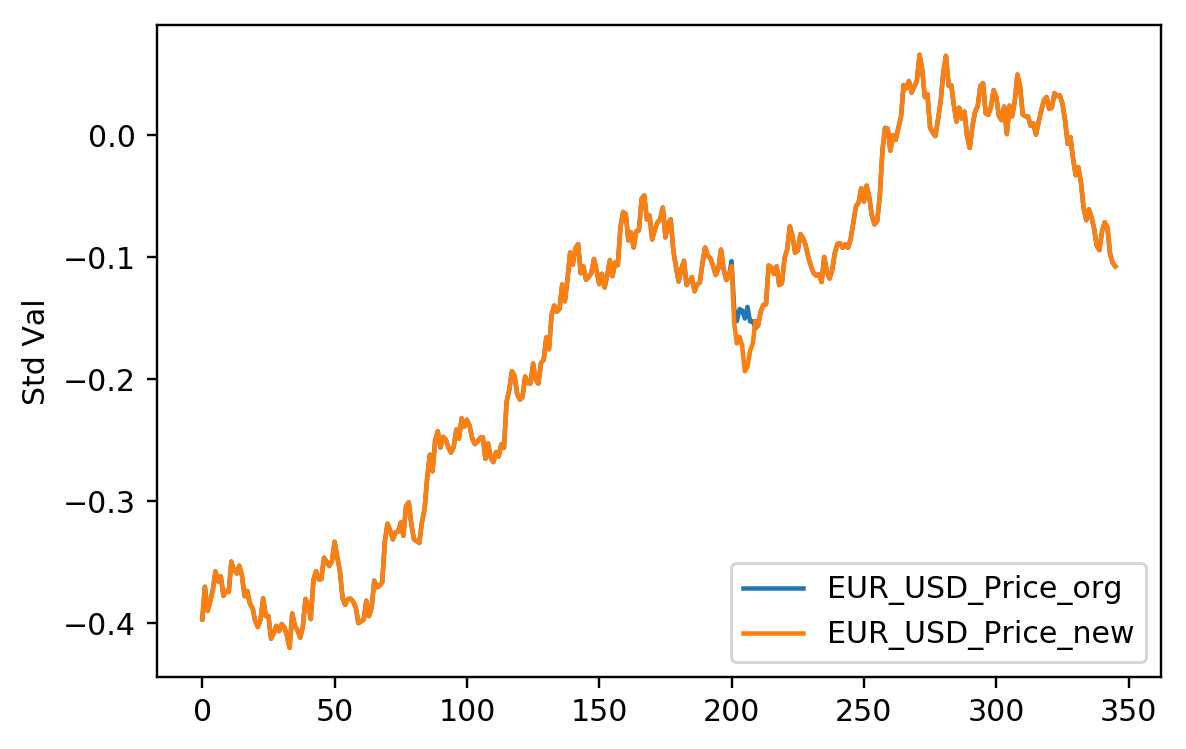

In [46]:
EUR_USD_Price_org = test_x['EUR_USD_Price'].copy()
new_price = EUR_USD_Price_org.copy()

new_price = dropval(new_price,position=200,days=5,percent=20)
test_x['EUR_USD_Price'] = new_price

fig, ax=plt.subplots(dpi=3*72)
ax.plot(range(0,346),EUR_USD_Price_org,label='EUR_USD_Price_org')
ax.plot(range(0,346),new_price,label='EUR_USD_Price_new')
plt.ylabel('Std Val')
ax.legend(loc='lower right')


In [47]:
test_x_vals = test_x.values
test_X = test_x_vals.reshape((test_x.shape[0],1, test_x.shape[1]))
pred2 = best_model.predict(test_X)
score = np.sqrt(metrics.mean_squared_error(pred2,test_y))
test_x['JPY_USD_Price'] = JPY_USD_Price_org
test_x['Nikkei_225_Price'] = Nikkei_225_Price_org
test_x['EUR_USD_Price'] = EUR_USD_Price_org

print("Score (RMSE): {}".format(score))

Score (RMSE): 0.02083695113556521


In [48]:
print(np.sqrt(metrics.mean_squared_error(pred2,preds)))

9.6314834e-05


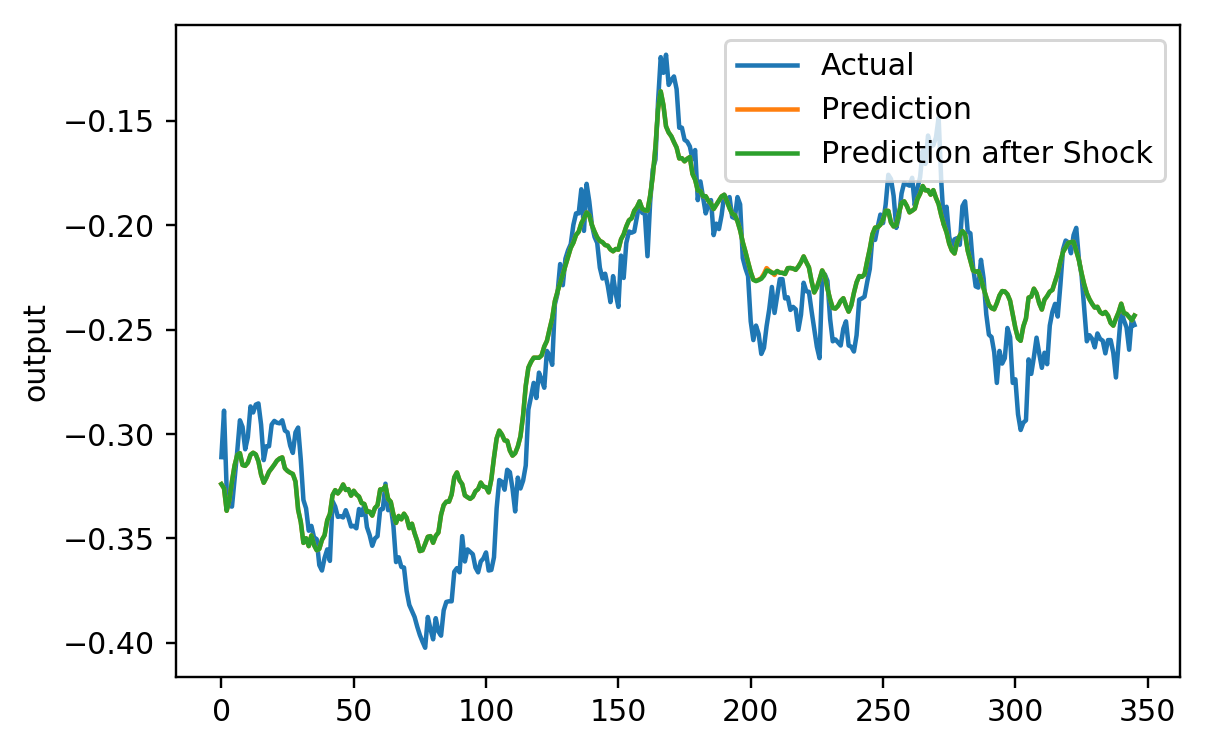

In [49]:
fig, ax = plt.subplots(dpi=3*72)
plt.plot(range(0,346),test_y,label='Actual')
plt.plot(range(0,346),preds,label='Prediction')
plt.plot(range(0,346), pred2,label='Prediction after Shock')
plt.ylabel('output')
ax.legend(loc='upper right')

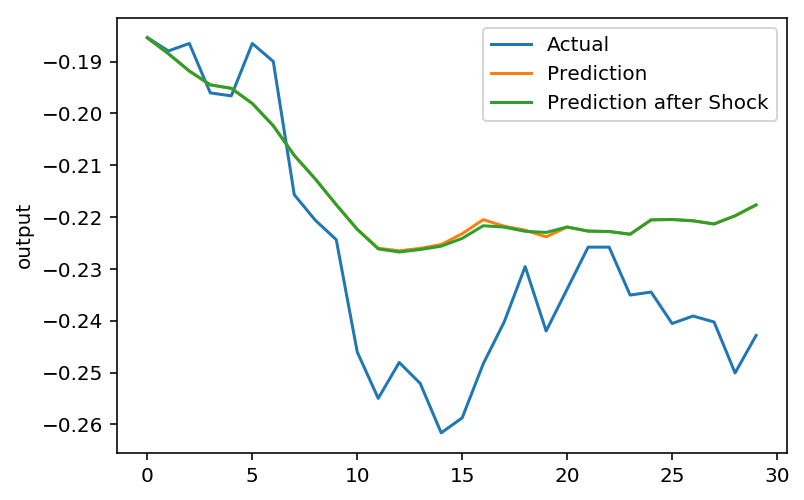

In [50]:
fig, ax = plt.subplots(dpi=2*72)
plt.plot(range(0,30),test_y[190:220],label='Actual')
plt.plot(range(0,30),preds[190:220],label='Prediction')
plt.plot(range(0,30), pred2[190:220],label='Prediction after Shock')
plt.ylabel('output')
ax.legend(loc='upper right')

In [51]:
train_x = train_data['Canada_30Y_BY_Price']
test_x = test_data['Canada_30Y_BY_Price']
train_y = train_dep['Canada_30Y_BY_Price']
test_y = test_dep['Canada_30Y_BY_Price']

In [52]:
train_x = pd.concat([train_x, lagged_data.iloc[:train_index,:]], axis=1)

In [53]:
test_x = pd.concat([test_x, lagged_data.iloc[train_index:,:]], axis=1)

In [54]:
train_x_vals = train_x.values
train_X = train_x_vals.reshape((train_x.shape[0],1, train_x.shape[1]))
test_x_vals = test_x.values
test_X = test_x_vals.reshape((test_x.shape[0],1, test_x.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1395, 1, 55) (1395,) (346, 1, 55) (346,)


In [55]:
input_layer = Input(shape=(train_X.shape[1], train_X.shape[2],), dtype='float32')
# design network

lstm_layer1 = LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='linear')(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer1)
lstm_layer2 = LSTM(50, input_shape=(train_X.shape[1], 100), return_sequences=True, activation='relu')(dropout_layer)
dropout_layer = Dropout(0.2)(lstm_layer2)
lstm_layer3 = LSTM(30, input_shape=(train_X.shape[1], 50), return_sequences=True, activation='relu')(dropout_layer)
dropout_layer = Dropout(0.2)(lstm_layer3)
lstm_layer4 = LSTM(10, input_shape=(train_X.shape[1], 30), return_sequences=False, activation='relu')(dropout_layer)
dropout_layer = Dropout(0.2)(lstm_layer4)

output_layer = Dense(1, activation='linear')(dropout_layer)

ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mae', optimizer='adam')

ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 55)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1, 100)            62400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 100)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 50)             30200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 1, 30)             9720      
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 30)             0         
__________

In [56]:

save_weights_at  = 'Canada_30Y_best.hdf5'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
fit_res = ts_model.fit(x=train_X, y=train_y, epochs=50,
             verbose=1, callbacks=[save_best], validation_data=(test_X, test_y),
             shuffle=False)

Train on 1395 samples, validate on 346 samples
Epoch 1/50
1395/1395 [==============================] - 5s 3ms/step - loss: 0.1920 - val_loss: 0.0851
Epoch 2/50
1395/1395 [==============================] - 0s 220us/step - loss: 0.1744 - val_loss: 0.0425
Epoch 3/50
1395/1395 [==============================] - 0s 185us/step - loss: 0.1764 - val_loss: 0.0493
Epoch 4/50
1395/1395 [==============================] - 0s 192us/step - loss: 0.1156 - val_loss: 0.0484
Epoch 5/50
1395/1395 [==============================] - 0s 190us/step - loss: 0.0832 - val_loss: 0.0482
Epoch 6/50
1395/1395 [==============================] - 0s 179us/step - loss: 0.0781 - val_loss: 0.0591
Epoch 7/50
1395/1395 [==============================] - 0s 183us/step - loss: 0.0736 - val_loss: 0.0523
Epoch 8/50
1395/1395 [==============================] - ETA: 0s - loss: 0.089 - 0s 183us/step - loss: 0.0891 - val_loss: 0.0519
Epoch 9/50
1395/1395 [==============================] - 0s 183us/step - loss: 0.0687 - val_loss: 0.

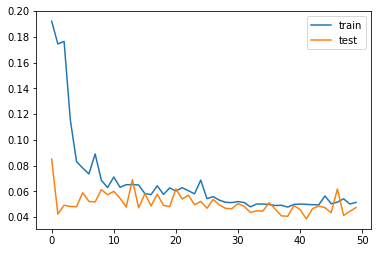

In [57]:
plt.plot(fit_res.history['loss'], label='train')
plt.plot(fit_res.history['val_loss'], label='test')
plt.legend()
plt.show()

In [58]:
best_model = load_model('Canada_30Y_best.hdf5')
preds = best_model.predict(test_X)

In [59]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_y, preds))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.045


Text(0.5,0,'Index')

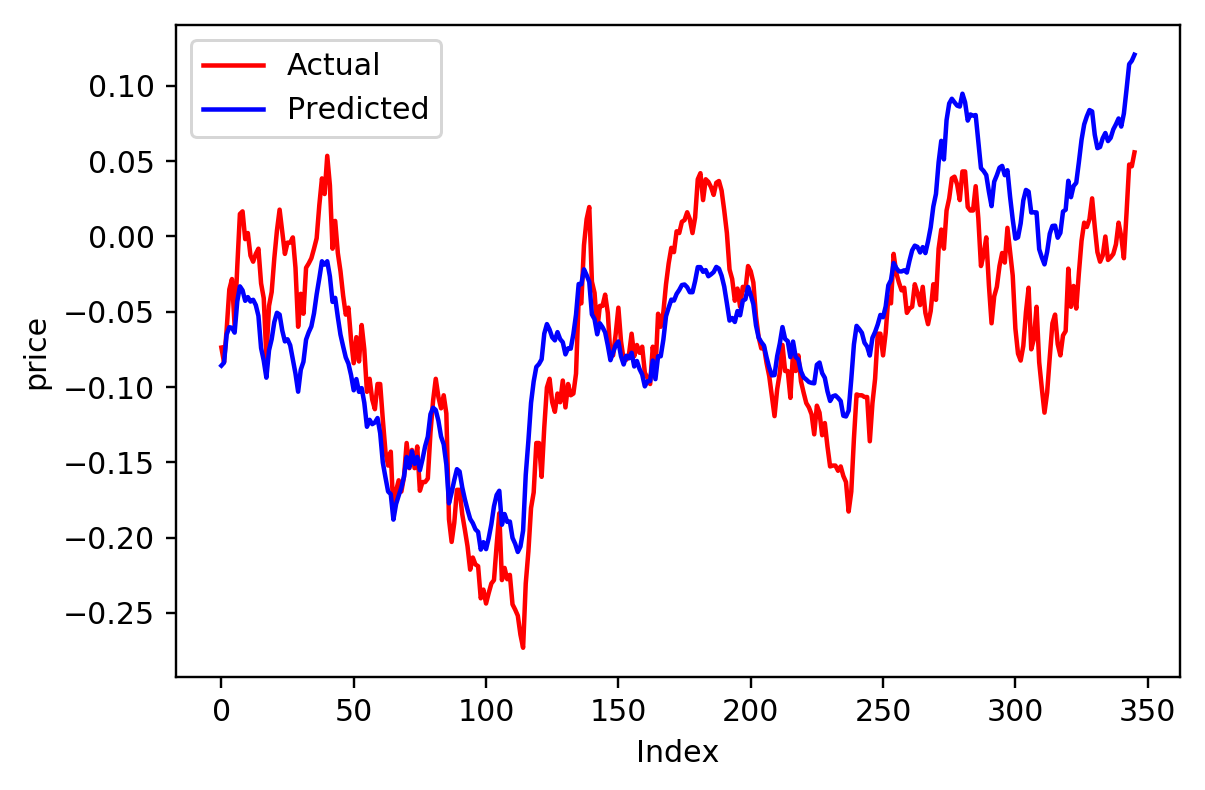

In [60]:
fig, ax = plt.subplots(dpi=3*72)
plt.plot(range(0,346), test_y, linestyle='-', color='r')
plt.plot(range(0,346), preds, linestyle='-', color='b')
plt.legend(['Actual','Predicted'], loc=2)
#plt.title('Actual vs Predicted pm2.5')
plt.ylabel('price')
plt.xlabel('Index')